# NeRF Test

In [1]:
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

import sys
import tensorflow as tf
import numpy as np
import imageio
import json
import random
import time
import cv2

from run_nerf_helpers import *
from nerf_renderer import *
from misc_helpers import *
from load_llff import load_llff_data

import matplotlib.pyplot as plt

In [2]:
HEIRARCHICAL_SAMPLING_METHOD = 2

In [3]:
def load_data(args):
    images, poses, bds, render_poses, i_test = load_llff_data(args.datadir, args.factor,
                                                                  recenter=True, bd_factor=.75,
                                                                  spherify=args.spherify)
    hwf = poses[0, :3, -1]
    H, W, focal = hwf
    H, W = int(H), int(W)

    poses = poses[:, :3, :4]
    print('Loaded llff', images.shape,
            render_poses.shape, hwf, args.datadir)

    print('DEFINING BOUNDS')
    if args.no_ndc:
        near = tf.reduce_min(bds) * .9
        far = tf.reduce_max(bds) * 1.
    else:
        near = 0.
        far = 1.
    print('NEAR FAR', near, far)   

    return images, poses, H, W, focal, near, far, bds, render_poses

In [4]:
if HEIRARCHICAL_SAMPLING_METHOD == 1:
    args_file = './data/rubiks/cropped/logs/rubiks/args.txt'
else:
    args_file = './data/rubiks2/logs/rubiks2/args.txt'
args = ConfigReader(args_file)

embed_fn, input_ch = get_embedder(args.multires, args.i_embed)

input_ch_views = 0
embeddirs_fn = None
if args.use_viewdirs:
    embeddirs_fn, input_ch_views = get_embedder(
        args.multires_views, args.i_embed)
output_ch = 4
skips = [4]
model = init_nerf_model(
    D=args.netdepth, W=args.netwidth,
    input_ch=input_ch, output_ch=output_ch, skips=skips,
    input_ch_views=input_ch_views, use_viewdirs=args.use_viewdirs)

model_fine = None
model_fine = init_nerf_model(
    D=args.netdepth_fine, W=args.netwidth_fine,
    input_ch=input_ch, output_ch=output_ch, skips=skips,
    input_ch_views=input_ch_views, use_viewdirs=args.use_viewdirs)

def network_query_fn(inputs, viewdirs, network_fn): return run_network(
    inputs, viewdirs, network_fn,
    embed_fn=embed_fn,
    embeddirs_fn=embeddirs_fn,
    netchunk=args.netchunk)

render_kwargs = {
    'network_query_fn': network_query_fn,
    'perturb': args.perturb,
    'N_importance': args.N_importance,
    'network_fine': model_fine,
    'N_samples': args.N_samples,
    'network_fn': model,
    'use_viewdirs': args.use_viewdirs,
    'white_bkgd': args.white_bkgd,
    'raw_noise_std': args.raw_noise_std,
    'chunk': args.chunk,
    'ndc': False,
    'lindisp': args.lindisp
}

print(render_kwargs)

MODEL_NERF 63 27 <class 'int'> <class 'int'> True
(None, 90) (None, 63) (None, 27)
MODEL_NERF 63 27 <class 'int'> <class 'int'> True
(None, 90) (None, 63) (None, 27)
{'network_query_fn': <function network_query_fn at 0x000002AEB12A4948>, 'perturb': 1.0, 'N_importance': 128, 'network_fine': <tensorflow.python.keras.engine.functional.Functional object at 0x000002AEB78DF4C8>, 'N_samples': 64, 'network_fn': <tensorflow.python.keras.engine.functional.Functional object at 0x000002AEB13CCCC8>, 'use_viewdirs': True, 'white_bkgd': False, 'raw_noise_std': 1.0, 'chunk': 32768, 'ndc': False, 'lindisp': False}


In [5]:
if HEIRARCHICAL_SAMPLING_METHOD == 1:
    model_coarse_weights_file = 'data/rubiks/cropped/logs/rubiks/model_500000.npy'
    model_fine_weights_file = 'data/rubiks/cropped/logs/rubiks/model_fine_500000.npy'

    model.set_weights(np.load(model_coarse_weights_file, allow_pickle=True))
    model_fine.set_weights(np.load(model_fine_weights_file, allow_pickle=True))
else:
    model_coarse_weights_file = 'data/rubiks2/logs/rubiks2/model_350000.npy'
    model_fine_weights_file = 'data/rubiks2/logs/rubiks2/model_fine_350000.npy'

    model.set_weights(np.load(model_coarse_weights_file, allow_pickle=True))
    model_fine.set_weights(np.load(model_fine_weights_file, allow_pickle=True))

In [6]:
images, poses, H, W, focal, near, far, bds, render_poses = load_data(args)

Loaded image data (500, 500, 3, 132) [ 500.         500.        1098.8775858]
Loaded ./data/rubiks2/ 2.2962166918186226 11.288918670814095
Data:
(132, 3, 5) (132, 500, 500, 3) (132, 2)
HOLDOUT view is 128
Loaded llff (132, 500, 500, 3) (120, 3, 5) [ 500.      500.     1098.8776] ./data/rubiks2/
DEFINING BOUNDS
NEAR FAR tf.Tensor(0.46544135, shape=(), dtype=float32) tf.Tensor(2.5425055, shape=(), dtype=float32)


In [18]:
import time
i = 43

results = []

for ns in [64, 32, 16]:
    for ni in [128, 64, 32, 16, 8]:
        print(ns, ni)
        render_kwargs['N_samples'] = ns
        render_kwargs['N_importance'] = ni

        start = time.time()
        rgb, disp, acc, _ = render(H, W, focal, near=near, far=far, c2w=poses[i, :3, :4], retraw=False, **render_kwargs)
        elapsed = time.time() - start
        psnr = mse2psnr(img2mse(images[i], rgb))
        _psnr = psnr.numpy().item()
        results.append([ns, ni, elapsed, psnr.numpy()])
        
        plt.imsave(f'outputs/ns_ni_test/{ns}_{ni}_{round(elapsed, 3)}_{round(_psnr, 3)}.png', rgb.numpy())

results = np.array(results, dtype = np.float32)
with open(f'outputs/ns_ni_test/results.npy', 'wb') as f:
    np.save(f, results)

print('FINISHED')

64 128
64 64
64 32
64 16
64 8
32 128
32 64
32 32
32 16
32 8
16 128
16 64
16 32
16 16
16 8
FINISHED


In [19]:
results

array([[ 64.      , 128.      ,  55.488823,  34.205296],
       [ 64.      ,  64.      ,  41.34546 ,  32.720158],
       [ 64.      ,  32.      ,  35.767   ,  29.811947],
       [ 64.      ,  16.      ,  33.294456,  26.29906 ],
       [ 64.      ,   8.      ,  27.216236,  23.28899 ],
       [ 32.      , 128.      ,  38.872314,  30.423449],
       [ 32.      ,  64.      ,  26.599564,  28.148983],
       [ 32.      ,  32.      ,  18.497694,  25.17192 ],
       [ 32.      ,  16.      ,  17.552921,  22.136   ],
       [ 32.      ,   8.      ,  14.922509,  19.824347],
       [ 16.      , 128.      ,  32.60069 ,  23.669123],
       [ 16.      ,  64.      ,  18.629911,  21.819834],
       [ 16.      ,  32.      ,  14.412422,  19.76822 ],
       [ 16.      ,  16.      ,   9.34951 ,  17.901674],
       [ 16.      ,   8.      ,   8.898901,  16.494432]], dtype=float32)

In [21]:
np.round(2.22222, 3)

2.222

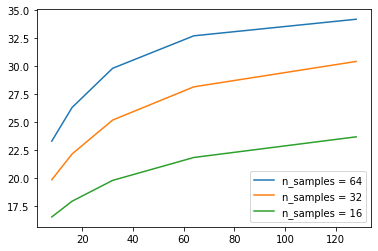

In [27]:
plt.plot(results[:5, 1], results[:5, 3], label = 'n_samples = 64')
plt.plot(results[5:10, 1], results[5:10, 3], label = 'n_samples = 32')
plt.plot(results[10:15, 1], results[10:15, 3], label = 'n_samples = 16')
plt.legend()

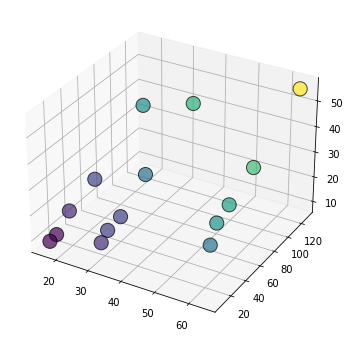

In [20]:
x, y, z = results[:, 0], results[:, 1], results[:, 2]
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z,
           linewidths=1, alpha=.7,
           edgecolor='k',
           s = 200,
           c=z)
plt.show()

In [ ]:
acc_ = acc.numpy()[..., np.newaxis]
acc_.dtype

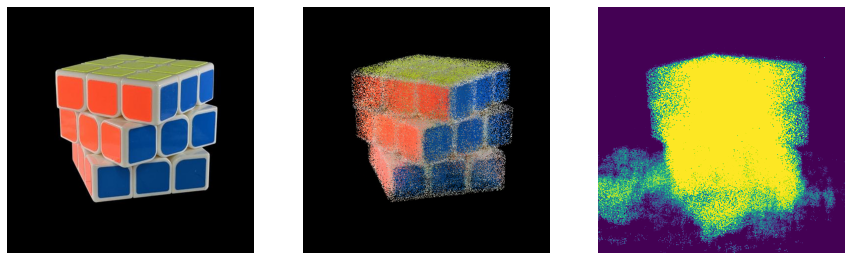

In [28]:
plot_images([images[i], rgb, acc_], 1, 3)

In [34]:
plt.imsave(f'outputs/acc_test/{i}_original.png', images[i])
plt.imsave(f'outputs/acc_test/{i}_rgb.png', rgb.numpy())
plt.imsave(f'outputs/acc_test/{i}_acc.png', acc.numpy(), cmap='gray')

In [7]:
def get_psnr(images, poses, near, far):
    rgbs = []
    psnrs = []    
    for i, target in enumerate(images):
        print('Rendering ', i + 1)
        rgb, _, _, _ = render(H, W, focal, near=near, far=far, c2w=poses[i, :3, :4], retraw=False, **render_kwargs)
        rgbs.append(rgb)
        psnr = mse2psnr(img2mse(rgb, target))
        psnrs.append(psnr)
        del rgb

    return rgbs, psnrs 

In [8]:
test_images = images[::8]
test_poses = poses[::8]
test_images.shape, test_poses.shape

((17, 500, 500, 3), (17, 3, 4))

In [9]:
rgbs, psnrs = get_psnr(images, poses, near, far)

Rendering  1
1
Rendering  2
1
Rendering  3
1
Rendering  4
1
Rendering  5
1
Rendering  6
1
Rendering  7
1
Rendering  8
1
Rendering  9
1
Rendering  10
1
Rendering  11
1
Rendering  12
1
Rendering  13
1
Rendering  14
1
Rendering  15
1
Rendering  16
1
Rendering  17
1
Rendering  18
1
Rendering  19
1
Rendering  20
1
Rendering  21
1
Rendering  22
1
Rendering  23
1
Rendering  24
1
Rendering  25
1
Rendering  26
1
Rendering  27
1
Rendering  28
1
Rendering  29
1
Rendering  30
1
Rendering  31
1
Rendering  32
1
Rendering  33
1
Rendering  34
1
Rendering  35
1
Rendering  36
1
Rendering  37
1
Rendering  38
1
Rendering  39
1
Rendering  40
1
Rendering  41
1
Rendering  42
1
Rendering  43
1
Rendering  44
1
Rendering  45
1
Rendering  46
1
Rendering  47
1
Rendering  48
1
Rendering  49
1
Rendering  50
1
Rendering  51
1
Rendering  52
1
Rendering  53
1
Rendering  54
1
Rendering  55
1
Rendering  56
1
Rendering  57
1
Rendering  58
1
Rendering  59
1
Rendering  60
1
Rendering  61
1
Rendering  62
1
Rendering  63
1
R

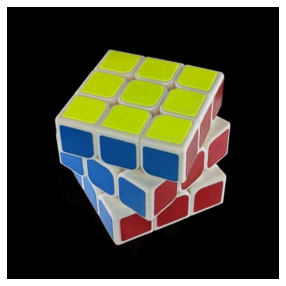

In [10]:
plot_images(rgbs, 1, 1)

In [10]:
psnrs

[<tf.Tensor: shape=(), dtype=float32, numpy=29.12305>,
 <tf.Tensor: shape=(), dtype=float32, numpy=30.803484>,
 <tf.Tensor: shape=(), dtype=float32, numpy=31.408445>,
 <tf.Tensor: shape=(), dtype=float32, numpy=31.83948>,
 <tf.Tensor: shape=(), dtype=float32, numpy=31.76444>,
 <tf.Tensor: shape=(), dtype=float32, numpy=31.708092>,
 <tf.Tensor: shape=(), dtype=float32, numpy=31.84049>,
 <tf.Tensor: shape=(), dtype=float32, numpy=31.149307>,
 <tf.Tensor: shape=(), dtype=float32, numpy=29.304049>,
 <tf.Tensor: shape=(), dtype=float32, numpy=30.76422>,
 <tf.Tensor: shape=(), dtype=float32, numpy=30.53245>,
 <tf.Tensor: shape=(), dtype=float32, numpy=30.757769>,
 <tf.Tensor: shape=(), dtype=float32, numpy=31.326279>,
 <tf.Tensor: shape=(), dtype=float32, numpy=31.174168>,
 <tf.Tensor: shape=(), dtype=float32, numpy=30.984243>,
 <tf.Tensor: shape=(), dtype=float32, numpy=30.847712>,
 <tf.Tensor: shape=(), dtype=float32, numpy=26.082506>,
 <tf.Tensor: shape=(), dtype=float32, numpy=28.63612>,

In [13]:
plt.imsave('outputs/res_sampling_test_img82.png', images[82])

In [11]:
mean_psnr = lambda x: tf.reduce_mean(x).numpy()

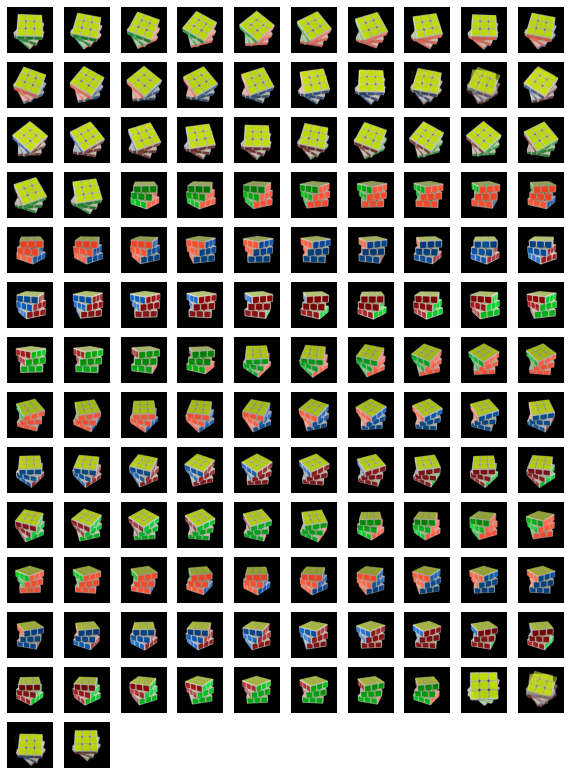

In [21]:
plot_images(rgbs, 14, 10, scale=1.0)

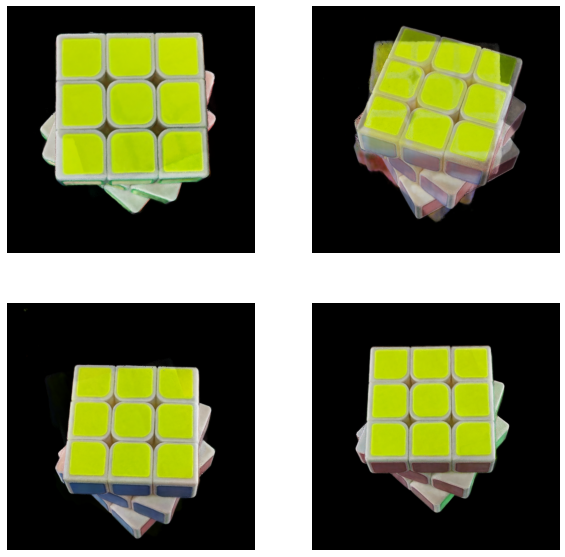

In [22]:
plot_images(rgbs[128:], 2, 2)

In [12]:
mean_psnr(psnrs)

31.461681

In [25]:
mean_psnr(psnrs[::8])

30.035856

In [13]:
i_test = np.arange(images.shape[0])[::8]
i_train = np.array([i for i in np.arange(int(images.shape[0])) if  i not in i_test])
train_psnrs = [psnrs[i] for i in i_train]

In [14]:
mean_psnr(psnrs[::8])

29.272549